# Problem 

A worldwide e-commerce site has localized versions of the site in Spanish. Managers noticed that Spain-based users have a much higher conversion rate than any other Spanish-speaking country. After talking to the international team in charge of Spain And Latin America(LatAm) about it, the Spain and LatAm country manager suggested that one reason could be translation. All Spanish- speaking countries originally had the same translation of the site which was written by a translator from Spain. 


# Proposed Solution

They agreed to try a test where each country would have its one translation written by a local (Argentinian users would see a translation written by an Argentinian, Mexican users by a Mexican, and so on), replicating what happened with Spanish users. As for users from Spain, they would have no change since their translation is already localized to Spanish.

## A. Hypothesis

Including a localized Spanish translation for each country's dialect will increase conversions for Spanish-speaking countries other than Spain.

## B. Metric

We will be using conversion as the metric to test our hypothesis. Conversion is defined as the number of customers who sign up for the company's website, given they have been exposed to the translation.

##  C. Experiment

Our goal from this experiment is to understand the effect of having local translation from each country on user conversion, which is done by randomly dividing visitors into equal groups for each country, and having one group (control group) exposed to the original Spanish translation, and the other (treatment group) exposed to a more localized Spanish translation. We want to measure conversion for each group after having been exposed to respective translations, and see whether having a localized translation results in a significant difference between conversions coming from users viewing the control version versus the treatment version.

It is estimated that about 80,000 shoppers from Spanish-speaking countries visit the website daily, and the company would want enough time to negotiate contracts before the holiday season if the result turns out favorable towards local translations. Therefore, the experiment will run for 5 days to allow for a sizeable sample, which is from the 30th of November to December 4th, giving enough time for the company to act on findings before the holidays.

First, the conversion ratio will be explored for both groups in order to have an idea of the effects of localizing translations. Then, a two-tailed statistical t-test will determine whether statistically significant difference exists, and whether it is worth introducing to the website. The two-tailed test will be used because we do not know which translation is likely to perform better, and therefore can use testing in two directions.

Let us start by importing Python libraries needed for our analysis, followed by importing the files and merging them into one dataframe:

user_id : the id of the user. Unique by user. Can be joined to user id in the other table.
For each user, we just check whether conversion happens the first time they land on the
site since the test started.

date : when they came to the site for the first time since the test started

source : marketing channel: Ads, SEO, Direct . Direct means everything except for ads
and SEO. Such as directly typing site URL on the browser, downloading the app w/o
coming from SEO or Ads, referral friend, etc.

device : device used by the user. It can be mobile or web

browser_language : in browser or app settings, the language chosen by the user. It can
be EN, ES, Other (Other means any language except for English and Spanish)

ads_channel : if marketing channel is ads, this is the site where the ad was displayed. It
can be: Google, Facebook, Bing, Yahoo ,Other. If the user didn't come via an ad, this
field is NA

browser : user browser. It can be: IE, Chrome, Android_App, FireFox, Iphone_App,
Safari, Opera

conversion : whether the user converted (1) or not (0). This is our label. A test is
considered successful if it increases the proportion of users who convert.

test : users are randomly split into test (1) and control (0). Test users see the new
translation and control the old one. For Spain-based users, this is obviously always 0
since there is no change there.

user_id : the id of the user. It can be joined to user id in the other table
sex : user sex: Male or Female
age : user age (self-reported)
country : user country based on ip address

In [29]:
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from scipy.stats import ttest_ind


In [30]:
# Import both data files
df = pd.read_csv("test_table.csv")
users = pd.read_csv("user_table.csv")

In [31]:
# Merge dataframes and delete them after
data = pd.merge(df, users , how='inner', on="user_id")

data.head()
len(data)

452867

In [32]:
data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,12/3/2015,Direct,Web,ES,NaN,IE,1,0,M,32,Spain
1,497851,12/4/2015,Ads,Web,ES,Google,IE,0,1,M,21,Mexico
2,848402,12/4/2015,Ads,Web,ES,Facebook,Chrome,0,0,M,34,Spain
3,290051,12/3/2015,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22,Mexico
4,548435,11/30/2015,Ads,Web,ES,Google,FireFox,0,1,M,19,Mexico


In [33]:
data.shape

(452867, 12)

Now that we have our dataframe ready, let us see the sizes of observations in control (test = 0) and treatment (test = 1) groups per country:

In [34]:
# Produce a summary dataframe, grouped by Country and test group with counts of each group:
sample_sizes = data[['country','test','conversion']].groupby(['country','test'], as_index=False).count()

# Produce a similar dataframe containing conversion ratios of each group:
conversions = data[['country','test','conversion']].groupby(['country','test'],as_index=False).sum()

# Merge dataframes, rename columns, re-index the new dataframe to have country column as index
summary = pd.merge(sample_sizes,conversions,on=['country','test'])
summary = summary.rename(columns={'conversion_x':'sample_size','conversion_y':'conversion'})


# Add a conversion ratio column, where the ratio = conversion/sample size
summary['conv_ratio'] = summary['conversion']/summary['sample_size']
summary.head()

,country,test,sample_size,conversion,conv_ratio
0,Argentina,0,9356,141,0.015071
1,Argentina,1,37377,513,0.013725
2,Bolivia,0,5550,274,0.049369
3,Bolivia,1,5574,267,0.047901
4,Chile,0,9853,474,0.048107


In [35]:
conversions

,country,test,conversion
0,Argentina,0,141
1,Argentina,1,513
2,Bolivia,0,274
3,Bolivia,1,267
4,Chile,0,474
5,Chile,1,507
6,Colombia,0,1411
7,Colombia,1,1364
8,Costa Rica,0,139
9,Costa Rica,1,145


Control and treament sample sizes generally seem to be balanced in all countries except Argentina and Uruguay. How much does data from these countries represent of the whole dataset?

In [36]:
Arg_Uru = (len(data[data['country']=='Argentina'])+len(data[data['country']=='Uruguay']))/len(data)*100
print(str(round(Arg_Uru,2))+'%')

11.23%


Alright, so 11% of a huge dataset can contain many conversions in one group or the other, biasing our results. Also, the dataset still contains visitors from Spain, which only applies as a control group. Based on this, observations from the 3 countries will be removed to rule out any bias that may invalidate our results. After that, we will visualize how conversions really look like for control and test groups:

In [37]:
# Remove observations from the 3 countries from the 'data' dataframe
data = data[data['country'] != 'Spain']
data = data[data['country'] != 'Argentina']
data = data[data['country'] != 'Uruguay']

# Remove observations from the 3 countries from the 'summary' dataframe
summary = summary[summary['country'] != 'Argentina']
summary = summary[summary['country'] != 'Spain']
summary = summary[summary['country'] != 'Uruguay']

print('data: {}'.format(len(data)))
print('summary: {}'.format(len(summary)))

data: 350218
summary: 28


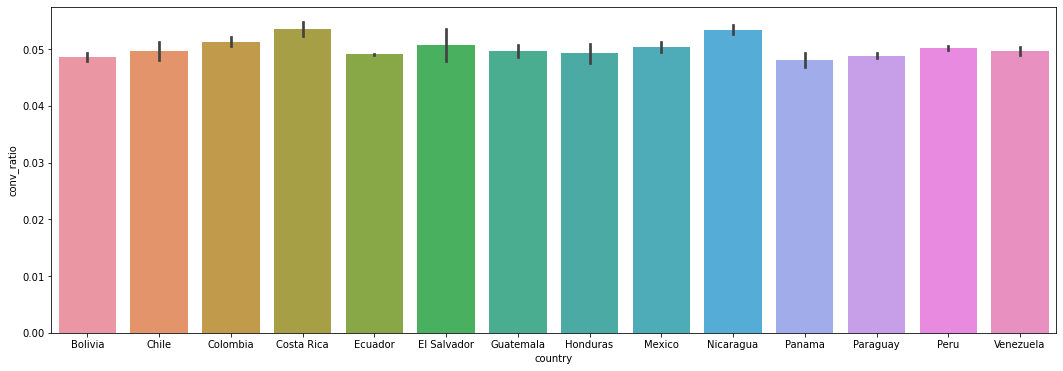

In [40]:

# Visualization
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='country', y='conv_ratio', data=summary, ax=ax)
plt.show()

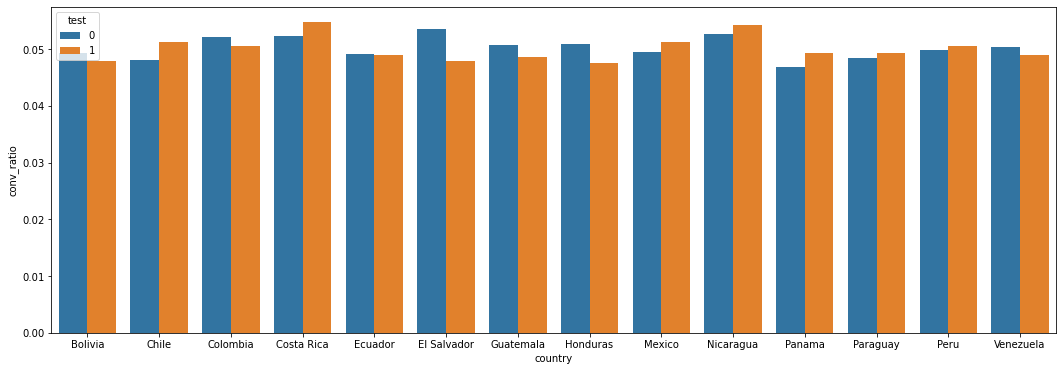

In [42]:
# Visualization

fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='country', y='conv_ratio', hue='test', data=summary, ax=ax)
plt.show()

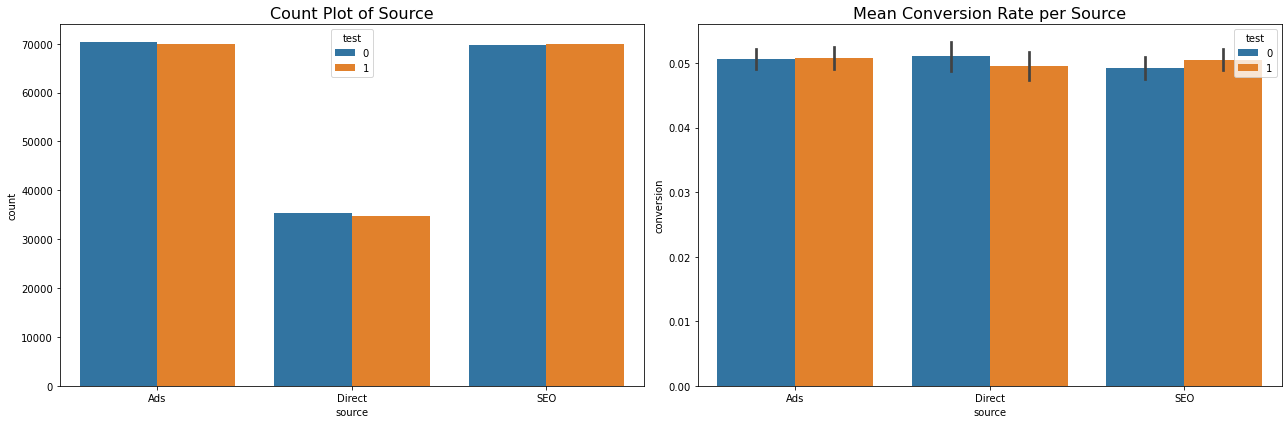

In [44]:
# Visualization of different source
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='source', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Source', fontsize=16)

sns.barplot(x='source', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Source', fontsize=16)
plt.tight_layout()
plt.show()

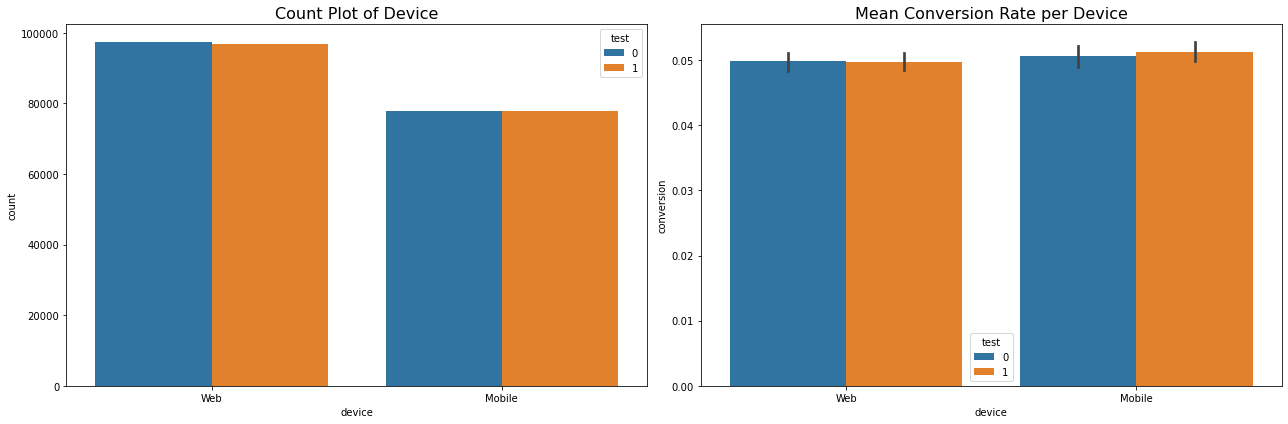

In [45]:
# Visualization of different devices
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='device', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Device', fontsize=16)

sns.barplot(x='device', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Device', fontsize=16)
plt.tight_layout()
plt.show()

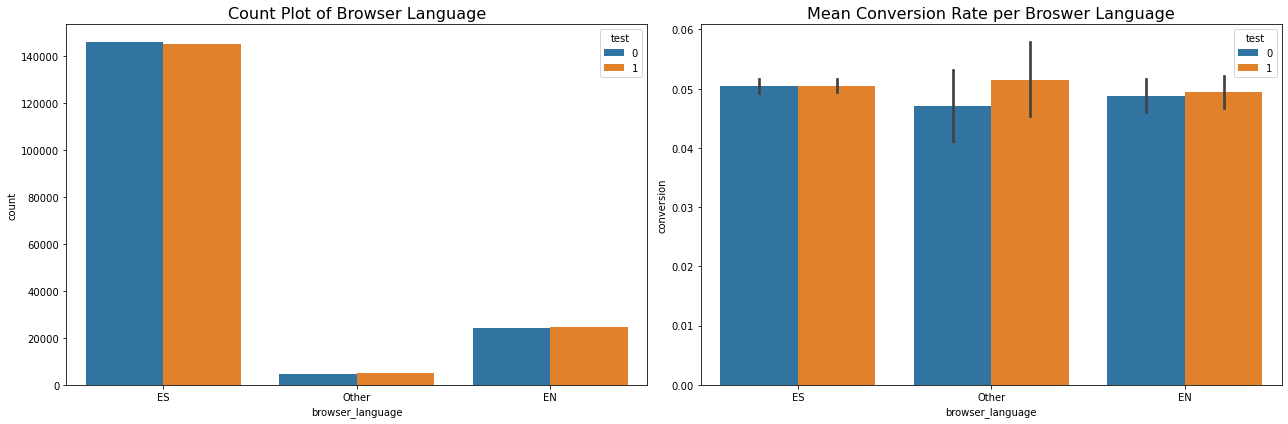

In [46]:
# Visualization of different devices
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='browser_language', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Browser Language', fontsize=16)

sns.barplot(x='browser_language', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Broswer Language', fontsize=16)
plt.tight_layout()
plt.show()

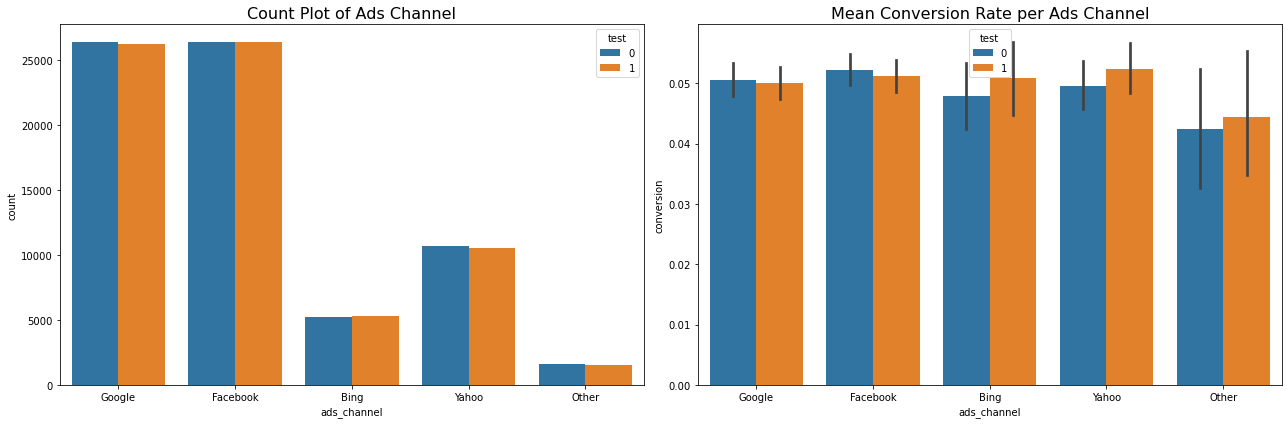

In [47]:
# Visualization of different devices
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='ads_channel', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Ads Channel', fontsize=16)

sns.barplot(x='ads_channel', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Ads Channel', fontsize=16)
plt.tight_layout()
plt.show()

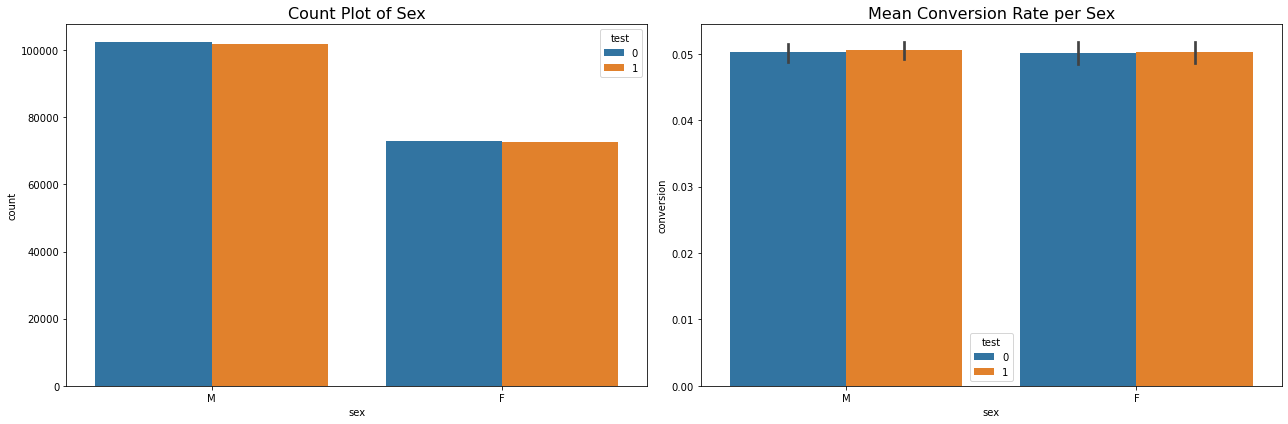

In [48]:
# Visualization of different devices
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='sex', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Sex', fontsize=16)

sns.barplot(x='sex', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Sex', fontsize=16)
plt.tight_layout()
plt.show()

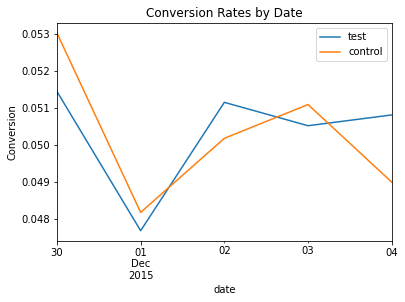

In [43]:
# Parse date column values to datetime
data["date"] = pd.to_datetime(data["date"], infer_datetime_format=True)

# Plot our dataframe
fig = data[data.test==1][
    ['date', 'conversion']].groupby('date').mean().plot()
data[data.test==0][
    ['date', 'conversion']].groupby('date').mean().plot(ax=fig)
plt.legend(['test','control'])
plt.title('Conversion Rates by Date')
plt.ylabel("Conversion")
plt.show()

Having removed imbalanced observations and visualized the rest, we can notice that conversions generally move in the same direction in time, with increasing conversions for both groups starting after December 1st and fluctuating after that. Conversions for the test group on December 2nd and 4th give hope that there may be significant difference in the website's performance in bringing in conversion. 

Next we will do a test of statistical power to determine whether the sample size needed to rely on the t-test we will be conducting, based on the following equation: $$n = \frac{2(\bar p)(1 - \bar p)(Z_p - Z)^2}{(p_1 - p_2)^2}$$ The function will take in the probability of each group, and give us the number of observations needed to infer with a certain degree of confidence:

In [15]:
# Power test to determine sample size for a certain stat power & significance level:
def sample_power_probtest(p1, p2, power=0.8, sig=0.05):
    z = stats.norm.isf([sig/2]) #two-sided t test
    zp = -1 * stats.norm.isf([power]) 
    d = (p1-p2)
    s =2*((p1+p2) /2)*(1-((p1+p2) /2))
    n = s * ((zp + z)**2) / (d**2)
    return int(round(n[0]))

p1 = data[data['test']==1]['conversion'].mean()
p2 = data[data['test']==0]['conversion'].mean()
sample_power_probtest(p1, p2)

10702973

This number is much higher than the sample size we have. This says that we do need to conduct another experiment that lasts at least about 4 months to get a meaningful result out of the analysis. However, for our current website needs we will carry on with our analysis to infer what we can about this experiment.

In [51]:
countries = [name for name in data['country'].unique() if name is not np.nan]

print('{0:15s} {1:>15s} {2:>15s} {3:>10s}'.format('Country', 'Test Rate', 'Control Rate', 'P-Value'))
print('-' * 65)
for country in countries:
    test_val = data[(data['country'] == country) & (data['test'] == 1)]['conversion'].values
    cont_val = data[(data['country'] == country) & (data['test'] == 0)]['conversion'].values
    
    test_mean = test_val.mean()
    cont_mean = cont_val.mean()
    p_val = ttest_ind(test_val, cont_val, equal_var=False).pvalue
    
    print('{0:15s} {1:15.5f} {2:15.5f} {3:10f}'.format(country, test_mean, cont_mean, p_val))

Country               Test Rate    Control Rate    P-Value
-----------------------------------------------------------------
Mexico                  0.05119         0.04949   0.165544
Venezuela               0.04898         0.05034   0.573702
Bolivia                 0.04790         0.04937   0.718885
Colombia                0.05057         0.05209   0.423719
El Salvador             0.04795         0.05355   0.248127
Nicaragua               0.05418         0.05265   0.780400
Peru                    0.05060         0.04991   0.771953
Costa Rica              0.05474         0.05226   0.687876
Chile                   0.05130         0.04811   0.302848
Ecuador                 0.04899         0.04915   0.961512
Guatemala               0.04865         0.05064   0.572107
Honduras                0.04754         0.05091   0.471463
Paraguay                0.04923         0.04849   0.883697
Panama                  0.04937         0.04680   0.705327


The results show no statistically significant difference in between the groups, evidenced by low t-values shown on the right of each list. Moreover, p-values are high, indicating that such a test needs a multitude of observations _(Seen above in the power test)_ to provide meaningful insight.

Even if we did not remove Argentina, Spain, and Uruguay, we would still have been left with small sample size, compared 

This means that as far as the results of our test, the groups show no difference, and we cannot reject the null hypothesis.

Before we get to the recommendation, we need to know what was the maximum difference in sample size were we willing to accept?

In [12]:
test_diff = []
ctrl_diff = []

# Subtract control & test sample sizes and get the maximum difference we accepted:
for val in np.unique(summary['country']):
        control = summary[summary['country']==val]['sample_size'].iloc[0]  
        test = summary[summary['country']==val]['sample_size'].iloc[1]
        c_diff = round(abs(test-control)/control*100,1)
        t_diff = round(abs(test-control)/test*100,1)
        ctrl_diff.append(c_diff)
        test_diff.append(t_diff)
        
print ('Max difference for control: '+str(max(ctrl_diff))+'%')
print ('Max difference for test: '+str(max(test_diff))+'%')

Max difference for control: 3.5%
Max difference for test: 3.7%


## Recommendation

Since our sample size is clearly too small to produce a significant result, we recommend the following to obtain a sample with a size that produces statistically significant result:

- Employing a randomization technique with the next experiment where the maximum difference between control and treatment groups for each country is  not more than 3.7% for any of them.

- Based on the number of daily visitors, replicating the same experiment on a period of no less than 5 months to obtain a sample size that we can reliably test, conclude from, and act upon.

- If possible, instantly introducing local translation at a small scale where cost is feasible to prepare for the larger experiment and anticipate any systematic issues.

